# Keras - PyTorch Gender and performance comparison

## Importing the libraries.

In [1]:

import numpy as np # Linear algebra
import pandas as pd

import warnings
warnings.filterwarnings("ignore")
# Memory monitoring
%load_ext memory_profiler 

import matplotlib.pyplot as plt
import seaborn as sns
# import cv2

from PIL import Image

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.functional as F
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,BatchNormalization
from sklearn.model_selection import train_test_split

In [2]:
%%time
%memit
data = pd.read_csv('./input/age_gender.csv')

## Converting pixels into numpy array
data['pixels']=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

data.head()

peak memory: 316.95 MiB, increment: 0.11 MiB
Wall time: 18.2 s


,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,"[129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 133..."
1,1,2,0,20161219222752047.jpg.chip.jpg,"[164.0, 74.0, 111.0, 168.0, 169.0, 171.0, 175...."
2,1,2,0,20161219222832191.jpg.chip.jpg,"[67.0, 70.0, 71.0, 70.0, 69.0, 67.0, 70.0, 79...."
3,1,2,0,20161220144911423.jpg.chip.jpg,"[193.0, 197.0, 198.0, 200.0, 199.0, 200.0, 202..."
4,1,2,0,20161220144914327.jpg.chip.jpg,"[202.0, 205.0, 209.0, 210.0, 209.0, 209.0, 210..."


In [3]:
print('Total rows: {}'.format(len(data)))
print('Total columns: {}'.format(len(data.columns)))

Total rows: 23705
Total columns: 5


## Distribution

In [4]:
## Normalizing pixels data
data['pixels'] = data['pixels'].apply(lambda x: x/255)

## Calculating distributions
age_dist = data['age'].value_counts()
ethnicity_dist = data['ethnicity'].value_counts().rename(index={0:'White',1:'Black',2:'Asian',3:'Indian',4:'Latin'})
gender_dist = data['gender'].value_counts().rename(index={0:'Male',1:'Female'})


def ditribution_plot(x,y,name):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(x,y)
    
    plt.xlabel(name)
    
    fig.show()

### Age distribution

In [5]:
# plt.figure(figsize=(40,5))

# sns.countplot(x='age',hue='gender',data=data)
# plt.xlabel('Age')
# plt.title('Age of people according to their gender')

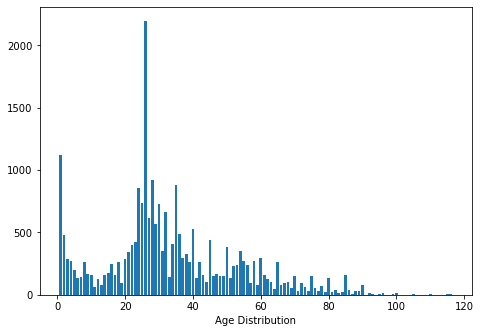

In [6]:
ditribution_plot(x=age_dist.index, y=age_dist.values, name='Age Distribution')

### Ethnicity distribution

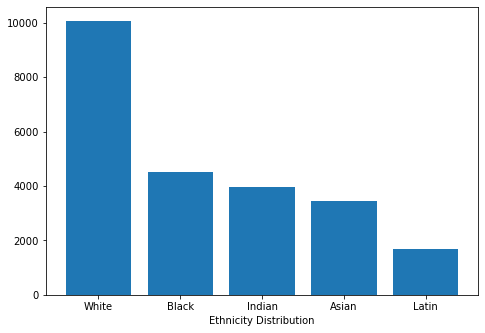

In [7]:
ditribution_plot(x=ethnicity_dist.index, y=ethnicity_dist.values, name='Ethnicity Distribution')

### Gender distribution

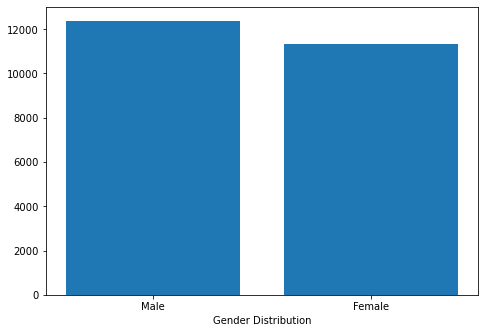

In [8]:
ditribution_plot(x=gender_dist.index, y=gender_dist.values, name='Gender Distribution')

In [9]:
X = np.array(data['pixels'].tolist())

## Converting pixels from 1D to 3D
X = X.reshape(X.shape[0],48,48,1)

## Sample Images

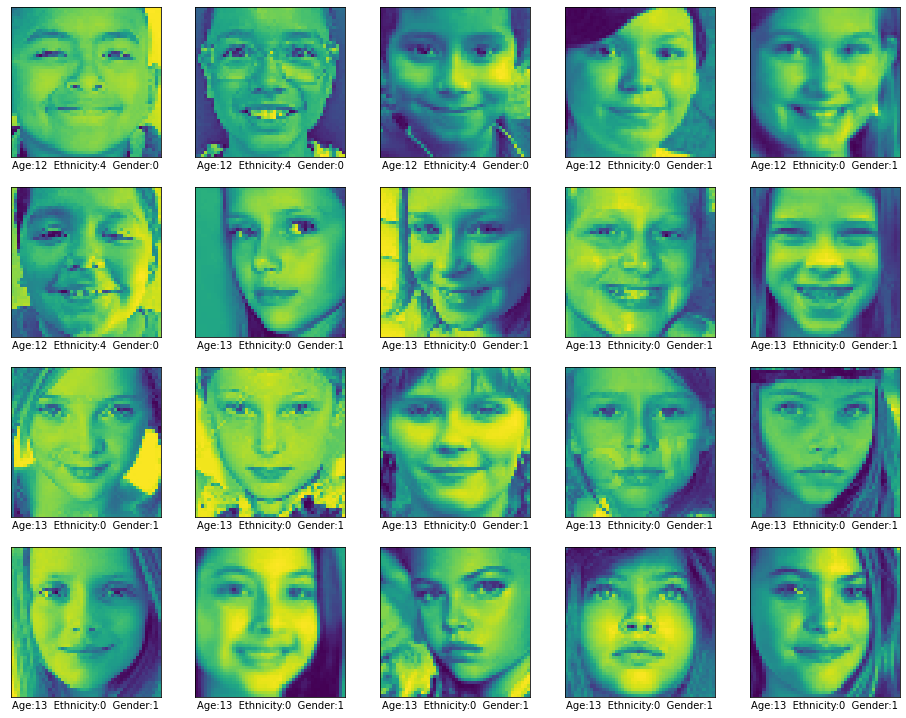

In [10]:
plt.figure(figsize=(16,16))
for i in range(1500,1520):
    plt.subplot(5,5,(i%25)+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data['pixels'].iloc[i].reshape(48,48))
    plt.xlabel(
        "Age:"+str(data['age'].iloc[i])+
        "  Ethnicity:"+str(data['ethnicity'].iloc[i])+
        "  Gender:"+ str(data['gender'].iloc[i])
    )
plt.show()

# TensorFlow based Keras - Model for Age Prediction

### Split data for training

In [49]:
y = data['age']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.22, random_state=37
)

### Build and train model

In [50]:
model = tf.keras.Sequential([
    L.InputLayer(input_shape=(48,48,1)),
    L.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    L.BatchNormalization(),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(64, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(128, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Flatten(),
    L.Dense(64, activation='relu'),
    L.Dropout(rate=0.5),
    L.Dense(1, activation='relu')
])

sgd = tf.keras.optimizers.SGD(momentum=0.9)

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])


## Stop training when validation loss reach 110
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<110):
            print("\nReached 110 val_loss so cancelling training!")
            self.model.stop_training = True
        
callback = myCallback()


model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
batch_normalization_2 (Batch (None, 46, 46, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 4, 128)        

In [51]:
%%time
%memit
history = model.fit(
    X_train, y_train, epochs=20, validation_split=0.1, batch_size=64, callbacks=[callback]
)

peak memory: 698.03 MiB, increment: 0.20 MiB
Epoch 1/20
260/260 [==============================] - 27s 102ms/step - loss: 333.3153 - accuracy: 0.0478 - val_loss: 1242.6500 - val_accuracy: 0.0141
Epoch 2/20
260/260 [==============================] - 27s 103ms/step - loss: 202.8475 - accuracy: 0.0470 - val_loss: 521.7263 - val_accuracy: 0.0384
Epoch 3/20
260/260 [==============================] - 27s 105ms/step - loss: 175.3993 - accuracy: 0.0450 - val_loss: 187.4333 - val_accuracy: 0.0373
Epoch 4/20
260/260 [==============================] - 27s 106ms/step - loss: 162.5816 - accuracy: 0.0409 - val_loss: 251.4760 - val_accuracy: 0.0427
Epoch 5/20
260/260 [==============================] - 27s 103ms/step - loss: 144.8026 - accuracy: 0.0386 - val_loss: 136.3909 - val_accuracy: 0.0416
Epoch 6/20
260/260 [==============================] - 27s 104ms/step - loss: 137.3859 - accuracy: 0.0362 - val_loss: 131.2203 - val_accuracy: 0.0276
Epoch 7/20
260/260 [==============================] - 27s 10

### Visualise Performance

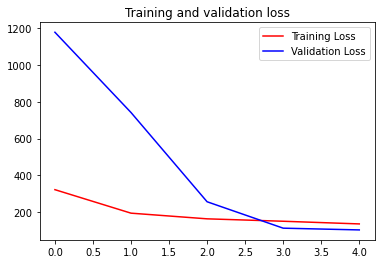

In [14]:
%matplotlib inline
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
mse, mae = model.evaluate(X_test,y_test,verbose=0)
print('Test Mean squared error: {}'.format(mse))
print('Test Mean absolute error: {}'.format(mae))

Test Mean squared error: 100.05524444580078
Test Mean absolute error: 7.4090776443481445


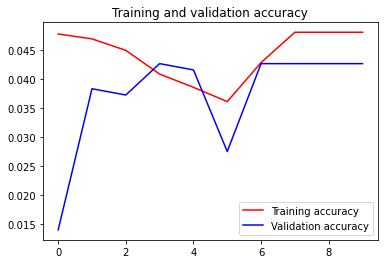

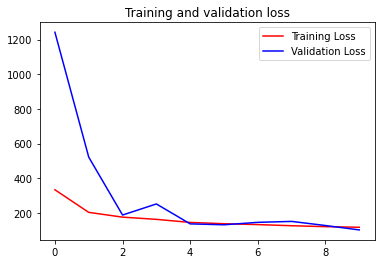

In [52]:
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Model for Ethnicity Prediction

### Split data for training

In [16]:
y = data['ethnicity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.22, random_state=37
)

### Build and train model

In [17]:
model = tf.keras.Sequential([
    L.InputLayer(input_shape=(48,48,1)),
    L.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(64, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Flatten(),
    L.Dense(64, activation='relu'),
    L.Dropout(rate=0.5),
    L.Dense(5)
])

model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


## Stop training when validation accuracy reach 79%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.790):
            print("\nReached 79% val_accuracy so cancelling training!")
            self.model.stop_training = True
        
callback = myCallback()


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                409664    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)               

In [18]:
%%time
%memit
history = model.fit(
    X_train, y_train, epochs=16, validation_split=0.1, batch_size=64, callbacks=[callback]
)

peak memory: 1022.66 MiB, increment: 0.00 MiB
Epoch 1/16
260/260 [==============================] - 15s 59ms/step - loss: 1.2323 - accuracy: 0.5273 - val_loss: 0.9200 - val_accuracy: 0.6766
Epoch 2/16
260/260 [==============================] - 15s 59ms/step - loss: 0.9749 - accuracy: 0.6558 - val_loss: 0.8045 - val_accuracy: 0.7204
Epoch 3/16
260/260 [==============================] - 15s 59ms/step - loss: 0.8919 - accuracy: 0.6907 - val_loss: 0.7704 - val_accuracy: 0.7301
Epoch 4/16
260/260 [==============================] - 15s 59ms/step - loss: 0.8355 - accuracy: 0.7118 - val_loss: 0.7579 - val_accuracy: 0.7317
Epoch 5/16
260/260 [==============================] - 15s 59ms/step - loss: 0.7896 - accuracy: 0.7268 - val_loss: 0.7054 - val_accuracy: 0.7555
Epoch 6/16
260/260 [==============================] - 15s 59ms/step - loss: 0.7568 - accuracy: 0.7407 - val_loss: 0.6870 - val_accuracy: 0.7637
Epoch 7/16
260/260 [==============================] - 15s 59ms/step - loss: 0.7256 - accur

### Visualise Performance

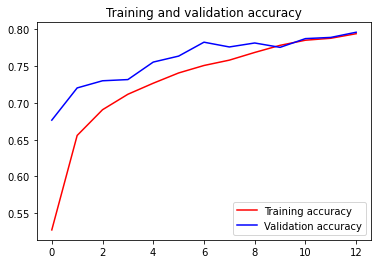

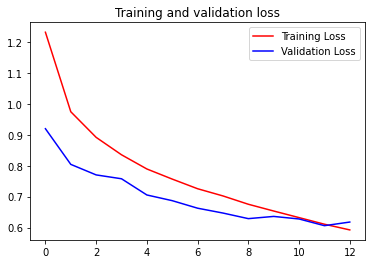

In [19]:
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Model for Gender Prediction

### Split data for training

In [20]:
y = data['gender']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.22, random_state=37
)

### Build and train model


In [21]:
model = tf.keras.Sequential([
    L.InputLayer(input_shape=(48,48,1)),
    L.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    L.BatchNormalization(),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(64, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Flatten(),
    L.Dense(64, activation='relu'),
    L.Dropout(rate=0.5),
    L.Dense(1, activation='sigmoid')
])

model.compile(optimizer='sgd',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])


## Stop training when validation loss reach 0.2700
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<0.2700):
            print("\nReached 0.2700 val_loss so cancelling training!")
            self.model.stop_training = True
        
callback = myCallback()

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [22]:
%%time
%memit
history = model.fit(
    X_train, y_train, epochs=20, validation_split=0.1, batch_size=64, callbacks=[callback]
)

peak memory: 1037.55 MiB, increment: 0.00 MiB
Epoch 1/20
260/260 [==============================] - 24s 94ms/step - loss: 0.5123 - accuracy: 0.7466 - val_loss: 0.5910 - val_accuracy: 0.8069
Epoch 2/20
260/260 [==============================] - 24s 92ms/step - loss: 0.3905 - accuracy: 0.8258 - val_loss: 0.3971 - val_accuracy: 0.8486
Epoch 3/20
260/260 [==============================] - 24s 91ms/step - loss: 0.3457 - accuracy: 0.8457 - val_loss: 0.3330 - val_accuracy: 0.8556
Epoch 4/20
260/260 [==============================] - 24s 91ms/step - loss: 0.3203 - accuracy: 0.8597 - val_loss: 0.3258 - val_accuracy: 0.8513
Epoch 5/20
260/260 [==============================] - 24s 91ms/step - loss: 0.3033 - accuracy: 0.8689 - val_loss: 0.3051 - val_accuracy: 0.8664
Epoch 6/20
260/260 [==============================] - 24s 93ms/step - loss: 0.2937 - accuracy: 0.8713 - val_loss: 0.3090 - val_accuracy: 0.8610
Epoch 7/20
260/260 [==============================] - 24s 92ms/step - loss: 0.2794 - accur

### Visualise Performance

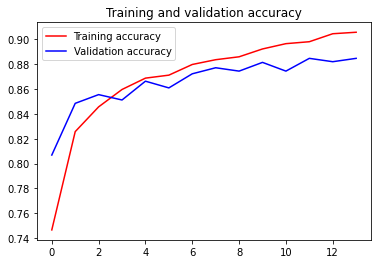

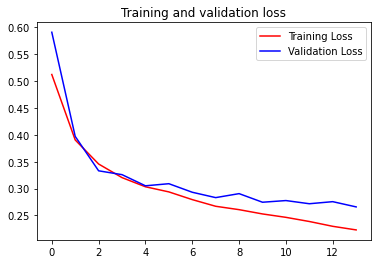

In [23]:
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [24]:
loss, acc = model.evaluate(X_test,y_test,verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.2525937259197235
Test Accuracy: 0.8851610422134399


In [25]:
# y_pred=model.predict(X_for_pred)
# y_pred[:5]

In [26]:
# Y_pred_classes = np.argmax(y_pred,axis = 1)

In [27]:
# Y_pred=['male' if i==0 else 'female' for i in Y_pred_classes]

In [28]:
# Y_pred[:5]

In [29]:
# index=np.random.randint(0,712,25) # predicted label and their images

# plt.figure(figsize=(16,16))

# for i in range(len(index)):
#     plt.subplot(5,5,(i%25)+1)
#     plt.grid(False)
#     plt.xticks([])
#     plt.yticks([])
#     plt.imshow(X_for_pred[index[i]].reshape(48,48))
#     plt.xlabel("Predicted Gender:"+str(Y_pred[index[i]])
#     )
    
# plt.show()

In [30]:
# #Confusion Matrix

# Y_true = np.argmax(y_for_pred,axis = 1) 

# # compute the confusion matrix
# confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

# # plot the confusion matrix
# f,ax = plt.subplots(figsize=(8, 8))
# sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix")
# plt.show()

## Gender Classification(Pytorch) By *********

In [31]:
data.gender=data.gender.astype('object')
data.ethnicity=data.ethnicity.astype('object')

In [32]:
# Labels for images
from keras.utils import to_categorical

Y_age=np.array([data.age]).T
Y_Gender=np.array(to_categorical(data.gender))
Y_Ethnic=np.array(to_categorical(data.ethnicity))

In [33]:
from sklearn.preprocessing import LabelEncoder

le =LabelEncoder()

Y_Gender2=le.fit_transform(data.gender)

## Data Process

In [34]:
X.shape #I use this for Pytorch

(23705, 48, 48, 1)

In [35]:
X_new=X.reshape(23705,1,48,48)

In [36]:
Y_Gender2.shape

(23705,)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_new, Y_Gender2, test_size=0.3, random_state=42,shuffle=True)
X_test, X_for_pred, y_test, y_for_pred = train_test_split(X_test, y_test, test_size=0.1, random_state=42,shuffle=True)

In [38]:
x_train_tensor=torch.from_numpy(X_train)
print("x_train tensor size:",x_train_tensor.size())

y_train_label=torch.from_numpy(y_train)
print("y_train_label size:",y_train_label.size())


x_train tensor size: torch.Size([16593, 1, 48, 48])
y_train_label size: torch.Size([16593])


In [39]:
x_test_tensor=torch.from_numpy(X_test)
print("x_test tensor size:",x_test_tensor.size())

y_test_label=torch.from_numpy(y_test)
print("y_test_ label size:",y_test_label.size())

x_for_pred_tensor=torch.from_numpy(X_for_pred)
print("x_test tensor size:",x_for_pred_tensor.size())

y_for_pred_label=torch.from_numpy(y_for_pred)
print("y_test_ label size:",y_for_pred_label.size())

x_test tensor size: torch.Size([6400, 1, 48, 48])
y_test_ label size: torch.Size([6400])
x_test tensor size: torch.Size([712, 1, 48, 48])
y_test_ label size: torch.Size([712])


In [40]:
batch_size = 100
n_iters = 200
num_epochs = n_iters / (len(X_test) / batch_size)
num_epochs = int(num_epochs)

num_epochs

3

In [41]:
train=torch.utils.data.TensorDataset(x_train_tensor,y_train_label) # x ve y train birleştirildi
trainloader=torch.utils.data.DataLoader(train,batch_size=batch_size,shuffle=True) # data ya çeviriyoruz eğitime uygun hale geldi

    
test=torch.utils.data.TensorDataset(x_test_tensor,y_test_label) # x ve y train birleştirildi
testloader=torch.utils.data.DataLoader(test,batch_size=batch_size,shuffle=False)

for_pred=torch.utils.data.TensorDataset(x_for_pred_tensor,y_for_pred_label)
for_pred_loader=torch.utils.data.DataLoader(for_pred,batch_size=batch_size,shuffle=False)

### Building Model

In [42]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

        # Max pool 1
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        self.Batch1=nn.BatchNorm2d(16)
        self.Batch2=nn.BatchNorm2d(32)
        self.Batch3=nn.BatchNorm2d(64)
        self.Batch4=nn.BatchNorm2d(128)
        
        self.Drop1=nn.Dropout(0.2)
        self.Drop2=nn.Dropout(0.5)


        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.cnn4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        
        
        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(128 * 1 * 1, 128) 
        self.fc2=nn.Linear(128,256)
        self.fc3=nn.Linear(256,2)

    def forward(self, x):
 
        out = self.cnn1(x) 
        out = self.relu(out)
        out = self.maxpool(out)
        out=self.Batch1(out)
        out=self.Drop1(out)
 
        out = self.cnn2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out=self.Batch2(out)
        out=self.Drop1(out)
        
        out = self.cnn3(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out=self.Batch3(out)
        out=self.Drop1(out)
        
        out = self.cnn4(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out=self.Batch4(out)
        out=self.Drop1(out)
        

        # Resize
        # Original size: (100, 32, 7, 7)
        # out.size(0): 100
        # New out size: (100, 32*7*7)
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        
        out=self.Drop2(out)
        
        out=self.fc2(out)
        
        out=self.Drop2(out)
        
        out=self.fc3(out)

        return out

In [43]:
model = CNNModel()

learning_rate=0.001

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [44]:
print(model.parameters())

print(len(list(model.parameters())))

# Convolution 1: 16 Kernels
print(list(model.parameters())[0].size())

# Convolution 1 Bias: 16 Kernels
print(list(model.parameters())[1].size())

# Convolution 2: 32 Kernels with depth = 16
print(list(model.parameters())[2].size())

# Convolution 2 Bias: 32 Kernels with depth = 16
print(list(model.parameters())[3].size())

# Fully Connected Layer 1
print(list(model.parameters())[4].size())

# Fully Connected Layer Bias
print(list(model.parameters())[5].size())

<generator object Module.parameters at 0x000001A38A4476D0>
22
torch.Size([16, 1, 3, 3])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([32])
torch.Size([32])


In [45]:
%%time
%memit
loss_list=[]
accuracy_list=[]
iter_list=[]

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        # Load images
        images = images.requires_grad_()

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images.float())
        
        labels = labels.to(dtype=torch.long)
#         labels = torch.empty(batch_size, dtype=torch.float).random_(nb_classes)
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 10 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in testloader:
                # Load images
                images = images.requires_grad_()

                # Forward pass only to get logits/output
                outputs = model(images.float())

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct // total

            # Print Loss
            accuracy_list.append(accuracy)
            loss_list.append(loss.item())
            iter_list.append(iter)
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

peak memory: 1035.25 MiB, increment: 0.00 MiB
Iteration: 10. Loss: 0.6933214068412781. Accuracy: 61
Iteration: 20. Loss: 0.638526976108551. Accuracy: 66
Iteration: 30. Loss: 0.5745745301246643. Accuracy: 69
Iteration: 40. Loss: 0.5517748594284058. Accuracy: 71
Iteration: 50. Loss: 0.5942372679710388. Accuracy: 73
Iteration: 60. Loss: 0.6016631722450256. Accuracy: 74
Iteration: 70. Loss: 0.5512288808822632. Accuracy: 75
Iteration: 80. Loss: 0.443909227848053. Accuracy: 76
Iteration: 90. Loss: 0.47001826763153076. Accuracy: 76
Iteration: 100. Loss: 0.5493093132972717. Accuracy: 77
Iteration: 110. Loss: 0.3633979558944702. Accuracy: 78
Iteration: 120. Loss: 0.37821823358535767. Accuracy: 77
Iteration: 130. Loss: 0.4482826590538025. Accuracy: 79
Iteration: 140. Loss: 0.3646128177642822. Accuracy: 80
Iteration: 150. Loss: 0.39661887288093567. Accuracy: 81
Iteration: 160. Loss: 0.47345706820487976. Accuracy: 82
Iteration: 170. Loss: 0.448019802570343. Accuracy: 81
Iteration: 180. Loss: 0.341

### Visualise Performance

<Figure size 432x288 with 0 Axes>

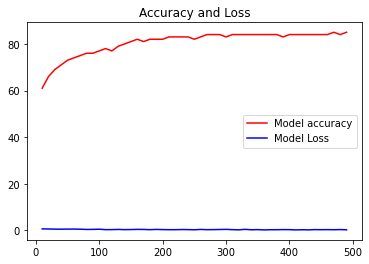

<Figure size 432x288 with 0 Axes>

In [46]:
%matplotlib inline
acc = accuracy_list
loss = loss_list
iteration=iter_list

plt.plot(iteration, acc, 'r', label='Model accuracy')
plt.plot(iteration, loss, 'b', label='Model Loss')
plt.title('Accuracy and Loss')
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

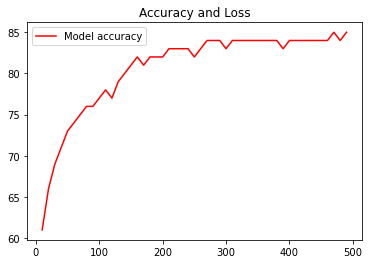

<Figure size 432x288 with 0 Axes>

In [47]:
plt.plot(iteration, acc, 'r', label='Model accuracy')
#plt.plot(iteration, loss, 'b', label='Model Loss')
plt.title('Accuracy and Loss')
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

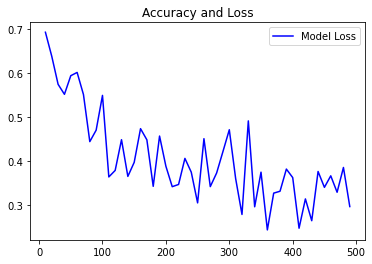

<Figure size 432x288 with 0 Axes>

In [48]:
#plt.plot(iteration, acc, 'r', label='Model accuracy')
plt.plot(iteration, loss, 'b', label='Model Loss')
plt.title('Accuracy and Loss')
plt.legend()
plt.figure()

In [53]:
plt.plot(iteration, loss, 'b', label='Model Loss')
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 94.08614349365234
Test Accuracy: 0.046587422490119934


In [55]:
plt.subplot(500, loss, 'b', label='Model Loss')

ValueError: invalid literal for int() with base 10: 'b'

<Figure size 432x288 with 0 Axes>